In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import mplhep as hep
import numpy as np
import sklearn.metrics as skl
import os
import mplhep as hep
import pathlib
from collections import namedtuple

import laspaclu.src.analysis.roc as roc
import laspaclu.src.util.logging as log
import laspaclu.src.util.string_constants as stco
import pofah.jet_sample as jesa
import anpofah.model_analysis.roc_analysis as ra

In [3]:
#****************************************#
#           Runtime Params
#****************************************#


Parameters = namedtuple('Parameters', 'sample_id_qcd sample_id_sigs read_n')
params = Parameters(sample_id_qcd='qcdSigExt',
                    sample_id_sigs=['GtoWW35na', 'GtoWW15br', 'AtoHZ35'], 
                    read_n=int(2e3))

#**********************************************************#
#    PLOT ALL SIGNALS, FIXED DIM=8, FIXED-N=600 (run 45)
#**********************************************************#

#****************************************#
#               READ DATA

run_n = 45
dim_z = 4
train_n = 600

In [4]:
input_data_dir = stco.cluster_out_data_dir+'/run_'+str(run_n)

sample_qcd = jesa.JetSample.from_input_file(name=params.sample_id_qcd, path=input_data_dir+'/'+params.sample_id_qcd+'.h5').filter(slice(params.read_n))

scores_qcd_c = sample_qcd['classic_loss']
scores_qcd_q = sample_qcd['quantum_loss']

ll_scores_sig_c = []; ll_scores_sig_q = []
for sample_id_sig in params.sample_id_sigs:
    sample_sig = jesa.JetSample.from_input_file(name=sample_id_sig, path=input_data_dir+'/'+sample_id_sig+'.h5').filter(slice(params.read_n))
    ll_scores_sig_c.append(sample_sig['classic_loss'])
    ll_scores_sig_q.append(sample_sig['quantum_loss'])

In [5]:
# plotting config
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

In [6]:
def prepare_truths_and_scores(scores_bg, scores_sig):
    
    y_truths = np.concatenate([np.zeros(len(scores_bg)), np.ones(len(scores_sig))])
    y_scores = np.concatenate([scores_bg, scores_sig])
    
    return y_truths, y_scores

In [38]:
def plot_roc(scores_bg_c, ll_scores_sig_c, scores_bg_q, ll_scores_sig_q, main_legend_labels, main_legend_title):
    
    plt.style.use(hep.style.CMS)
    line_styles = ['solid', 'dashed']
    fig = plt.figure(figsize=(8, 8))
    
    aucs = []
    for scores_sig_c, scores_sig_q, cc in zip(ll_scores_sig_c, ll_scores_sig_q, stco.multi_sig_palette):
        
        y_truths_q, y_scores_q = prepare_truths_and_scores(scores_bg_q, scores_sig_q)
        y_truths_c, y_scores_c = prepare_truths_and_scores(scores_bg_c, scores_sig_c)
        
        fpr_q, tpr_q, _ = skl.roc_curve(y_truths_q, y_scores_q)
        fpr_c, tpr_c, _ = skl.roc_curve(y_truths_c, y_scores_c)
            
        aucs.append(skl.roc_auc_score(y_truths_q, y_scores_q))
        aucs.append(skl.roc_auc_score(y_truths_c, y_scores_c))
        
        plt.loglog(tpr_q, 1./fpr_q, linestyle='solid', color=cc)
        plt.loglog(tpr_c, 1./fpr_c, linestyle='dashed', color=cc)
        
    # plot random decision line
    test_n = int(1e3)
    plt.loglog(np.linspace(0, 1, num=test_n), 1./np.linspace(0, 1, num=test_n), linewidth=1.2, linestyle='solid', color='silver')

    dummy_res_lines = [Line2D([0,1],[0,1],linestyle=s, color='gray') for s in line_styles[:2]]

    # add 2 legends (classic vs quantum and resonance types)
    lines = plt.gca().get_lines()
    
    legend1 = plt.legend(dummy_res_lines, [r'Quantum', r'Classic'], loc='lower left', frameon=False, title='algorithm', \
            handlelength=1.5, fontsize=14, title_fontsize=17, bbox_to_anchor=(0,0.28))
    
    main_legend_labels = [r"{:30s}".format(lbl) for lbl in main_legend_labels]
    legend2 = plt.legend([lines[i*len(line_styles)] for i in range(len(main_legend_labels))], main_legend_labels, loc='lower left', \
            frameon=False, title=main_legend_title, fontsize=14, title_fontsize=17)
    
    auc_legend_labels = [r"  {:.3f} $\vert$ {:.3f}".format(aucs[i*2],aucs[i*2+1]) for i in range(len(main_legend_labels))]
    auc_legend_title = r"AUC q $\vert$ c"
    legend3 = plt.legend([lines[i*len(line_styles)] for i in range(len(main_legend_labels))], auc_legend_labels, loc='lower center', \
            frameon=False, title=auc_legend_title, fontsize=14, title_fontsize=17) 
    
    legend1._legend_box.align = "left"
    legend2._legend_box.align = "left"
    legend3._legend_box.align = "center"
    for leg in legend1.legendHandles:
        leg.set_linewidth(2.2)
        leg.set_color('gray')
    for leg in legend2.legendHandles:
        leg.set_linewidth(2.2)
    for leg in legend3.legendHandles:
        leg.set_visible(False)
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)
    plt.gca().add_artist(legend3)
    
    plt.draw()
    
    # Get the bounding box of the original legend
    bb = legend3.get_bbox_to_anchor().inverse_transformed(plt.gca().transAxes)
    # Change to location of the legend. 
    xOffset = 0.07
    bb.x0 += xOffset
    bb.x1 += xOffset
    legend3.set_bbox_to_anchor(bb, transform = plt.gca().transAxes)
    
    plt.grid()
    plt.xlabel('True positive rate',fontsize=16)
    plt.ylabel('1 / False positive rate',fontsize=16)
    plt.tight_layout()
        
    plt.show()

/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/afs/cern.ch/user/k/kiwoznia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide

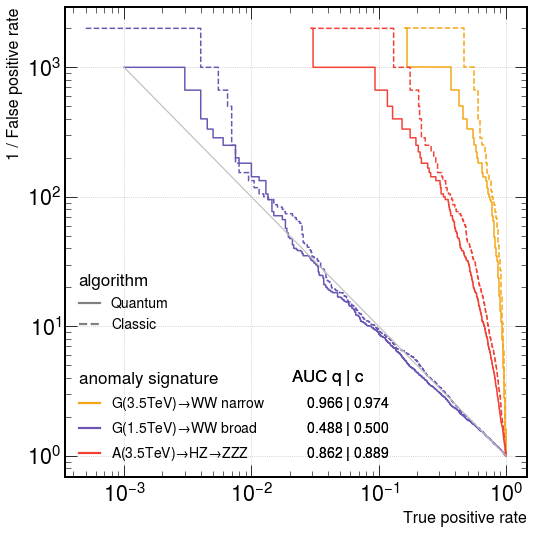

In [39]:
legend_labels = [stco.sample_name_dict[id_sig] for id_sig in params.sample_id_sigs]
legend_title = 'anomaly signature'
plot_roc(scores_qcd_c, ll_scores_sig_c, scores_qcd_q, ll_scores_sig_q, main_legend_labels=legend_labels, main_legend_title=legend_title)